In [128]:
import tensorflow as tf
import os

graph_def = tf.compat.v1.GraphDef()
labels = []

# These are set to the default names from exported models, update as needed.
filename = "model.pb"
labels_filename = "labels.txt"

# Import the TF graph
with tf.io.gfile.GFile(filename, 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

# Create a list of labels.
with open(labels_filename, 'rt') as lf:
    for l in lf:
        labels.append(l.strip())

In [129]:
from PIL import Image
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot as plt
import os
import json
import operator

# Utility function, rgb to hex
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex

def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    image = image.convert('RGB')
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_256_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)             
    return image

In [130]:
#統計資料夾中有幾張圖片
path = 'C:/Users/User/0612_Merge_Json/Test_Image_Cut' #要統計的資料夾
pic_count = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
print(pic_count)

10


Classified as: floral
[0.00107455 0.01025146 0.55913562 0.03080762 0.0195463  0.04891068] 0.5591356158256531
H:346.2097404288567
S:0.06848506738368193
V:0.9280296290165733
粉红色


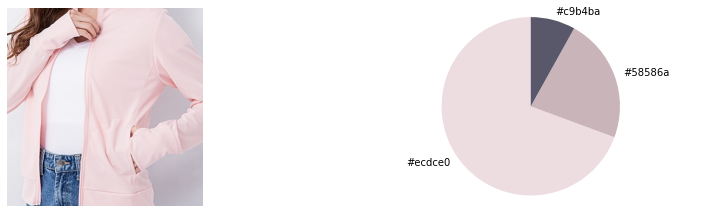


Classified as: stripe
[0.00136816 0.01925036 0.08720058 0.01834706 0.07342443 0.65589035] 0.6558903455734253
H:348.81245768449566
S:0.08987009299354012
V:0.911173328898006
粉红色


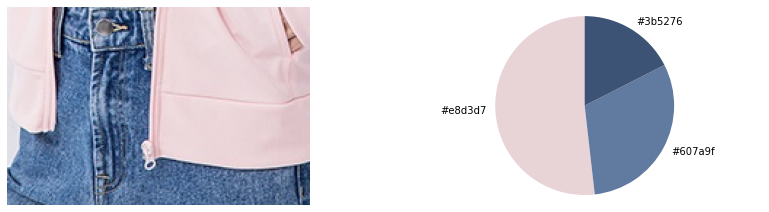


Classified as: dot
[0.00887337 0.2576853  0.01602122 0.03677806 0.01478669 0.06166568] 0.2576853036880493
H:8.591845003499197
S:0.1829422784059514
V:0.6473510872647168
粉红色


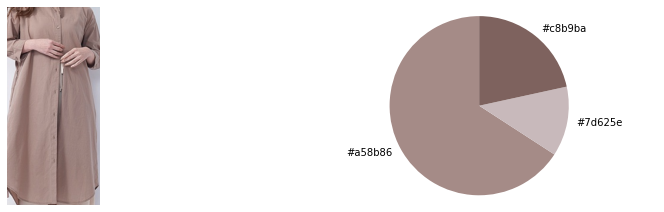


Classified as: floral
[6.15600002e-05 5.55477012e-03 9.48638260e-01 4.23398986e-03
 1.21450005e-03 8.49816017e-03] 0.9486382603645325
H:5.887368982057335
S:0.028867406856586054
V:0.9265181032025088
白色


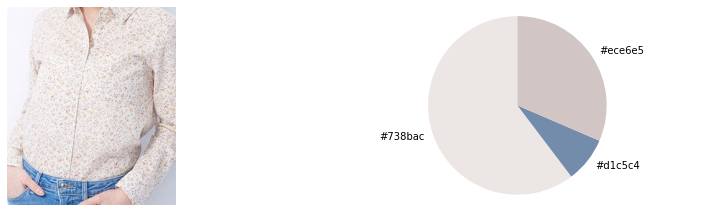


Classified as: floral
[7.89000023e-06 1.80304004e-03 8.54296744e-01 2.14958325e-01
 8.22737999e-03 2.63342708e-01] 0.8542967438697815
H:211.00636282434414
S:0.45781113138916446
V:0.76304749797758
藍色


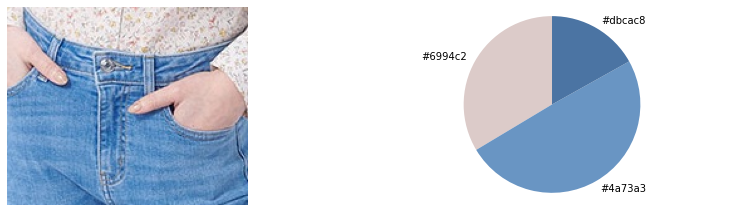

In [131]:
#把資料夾中的所有圖片經過此模型後存成一個個json檔
for filename in os.listdir(path):
    image=""
    if filename.endswith(".jpg"):
        # Load from a file
        #imageFile = "C:/Users/User/0601匯出分類器TensorFlow/Test_Image/NET_x_.jpg"
        #imageFile = imageFile.replace('x',str(pic))
        #image = Image.open(imageFile)
        image = Image.open(path+"/"+filename)
        
        #顏色圖片變數
        img = cv2.imread(os.path.join(path,filename))
        
        # Update orientation based on EXIF tags, if the file has orientation info.
        image = update_orientation(image)

        # Convert to OpenCV format
        image = convert_to_opencv(image)

        # If the image has either w or h greater than 1600 we resize it down respecting
        # aspect ratio such that the largest dimension is 1600
        image = resize_down_to_1600_max_dim(image)

        # We next get the largest center square
        h, w = image.shape[:2]
        min_dim = min(w,h)
        max_square_image = crop_center(image, min_dim, min_dim)

        # Resize that square down to 256x256
        augmented_image = resize_to_256_square(max_square_image)

        # Get the input size of the model
        with tf.compat.v1.Session() as sess:
            input_tensor_shape = sess.graph.get_tensor_by_name('Placeholder:0').shape.as_list()
            network_input_size = input_tensor_shape[1]

        # Crop the center for the specified network_input_Size
        augmented_image = crop_center(augmented_image, network_input_size, network_input_size)

        # These names are part of the model and cannot be changed.
        output_layer = 'loss:0'
        input_node = 'Placeholder:0'

        with tf.compat.v1.Session() as sess:
            try:
                prob_tensor = sess.graph.get_tensor_by_name(output_layer)
                predictions = sess.run(prob_tensor, {input_node: [augmented_image] })
            except KeyError:
                print ("Couldn't find classification output layer: " + output_layer + ".")
                print ("Verify this a model exported from an Object Detection project.")
                exit(-1)
        
        # Print the highest probability label
        highest_probability_index = np.argmax(predictions)
        #print('Classified as: ' + labels[highest_probability_index])
        print('Classified as: ' + str(labels[highest_probability_index]))
        
        # Or you can print out all of the results mapping labels to probabilities.
        label_index = 0

        #寫入json
        f1 = open(path+"/"+filename.split('.')[0]+".json", "w")#w代表覆蓋寫入
        f1.writelines(str("{'Classification':"+"'"+labels[highest_probability_index]+"'").replace("'",'"')+",")
        f1.close()
 
        f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#a代表附加寫入
        #for p in predictions:
        for p in predictions:
            truncated_probablity = np.float64(np.round(p,8))
            print (truncated_probablity,truncated_probablity[highest_probability_index])
            #print (labels[label_index], truncated_probablity,truncated_probablity[highest_probability_index])
            #f1.writelines(str("'Highest_probability':"+str(truncated_probablity[highest_probability_index])).replace("'",'"')+","+str("'Probablity':"+str(truncated_probablity)).replace("'",'"')+"}")
            f1.writelines(str("'Highest_probability':"+str(truncated_probablity[highest_probability_index])).replace("'",'"')+",")
            label_index += 1
        f1.close()
        
        #顏色
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # load image
        #取最高的 k 個顏色
        k=3 
       
        size = img.shape
        # 寬
        w = size[1] 
        # 高
        h = size[0] 
        # 裁切區域的 x 與 y 座標（左上角）
        x1 = int(w * 0.1)
        y1 = int(h * 0.9)
        # 裁切區域的 x 與 y 座標（右下角）
        x2 = int(w * 0.9)
        y2 = int(h * 0.1)
        # 裁切圖片
        img_rgb = img[y2:y1, x1:x2]   

        # resize image to speed up processing time
        resized_img_rgb = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)

        # reshape the image to be a list of pixels
        img_list = resized_img_rgb.reshape((resized_img_rgb.shape[0] * resized_img_rgb.shape[1], 3))

        # cluster the pixels and assign labels
        clt = KMeans(n_clusters=k)
        labels_col = clt.fit_predict(img_list)  

        # count labels to find most popular
        label_counts = Counter(labels_col)
        total_count = sum(label_counts.values())
        new_dict = dict(label_counts)
        sort_new_dict = sorted(new_dict.items(), key=lambda item: item[1])
           
        # 佔比最多的顏色 index
        key = sort_new_dict[k-1][0]
        # 顏色比例
        for i in range(0,len(new_dict)):
            p_arr = []
            count = new_dict.get(i)
            percent = round(count/total_count*100)
            #print(percent)

        # subset out most popular centroid
        # RGB
        center_colors = list(clt.cluster_centers_)
        ordered_colors = [center_colors[i]/255 for i in label_counts.keys()]
        color_labels = [rgb2hex(ordered_colors[i]*255) for i in label_counts.keys()]   
    
        main_color_rgb = center_colors[key]
        #print(main_color_rgb)

        sort_main_color_rgb = sorted(main_color_rgb)             
            
        # RGB轉 HSV
        R = main_color_rgb[0]/255 
        G = main_color_rgb[1]/255 
        B = main_color_rgb[2]/255 
            
        max_num = sort_main_color_rgb[k-1]/255 
        min_num = sort_main_color_rgb[0]/255 
        d = max_num - min_num

        V = max_num          
            
        if max_num == 0:
            S = 0
        else:
            S = d/max_num
            
        if d == 0:
            H = 0
        if R == max_num and G >= B: 
            H = ( (G-B)/ d )* 60
        if R == max_num and G < B:
            H = ( (G-B)/ d )* 60 + 360
        if G == max_num:
            H = ( (B-R)/ d )* 60 + 120
        if B == max_num:
            H = ( (R-G)/ d )* 60 + 240
            
        print('H:'+str(H))
        print('S:'+str(S))
        print('V:'+str(V))
            
        Smin = 0.045
        Vmin = 65/255
        Vmax = 0.75
        
        if S > 0.06 and S <= 0.14 and V > Vmax:
            if H < 24 or ( H >= 310 and H <= 360 ):
                color = "pink"
                print("粉红色")    
                f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                f1.close()
                    
            if H >= 24 and H < 110 :
                if H >= 45 and H <= 70:
                    color = "yellow"
                    print("黄色")   
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                else:
                    color = "creamy-white"
                    print("米白色")   
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()

            if H>=110 and H<200 :
                color = "light green"
                print("淺綠色")
                f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                f1.close()

            if H>=200 and H<250 :
                color = "light blue"
                print("淺藍色")
                f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                f1.close()

            if H>=250 and H<310 :
                color = "light purple"
                print("淺紫色")   
                f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                f1.close()
        
        elif S > 0.14 and V > Vmin:
            if H < 20 or ( H >= 310 and H <= 360 ):
                if S >= 0.5 and V <= 0.55:
                    color = "dark red"
                    print("酒红色")
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                elif S < 0.45 and V > 0.55:
                    color = "pink"
                    print("粉红色") 
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                else:
                    color = "red"
                    print("红色")
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                    
            if H >= 20 and H < 45 :
                if S < 0.24 and V >= 0.7:
                    color = "creamy-white"
                    print("米白色") 
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                    
                elif S < 0.24 and V < 0.7 and V > 0.6:
                    color = "pink"
                    print("粉红色") 
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                    
                elif V <= 0.75:
                    color = "brown"
                    print("咖啡色")
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                    
                elif V <= 0.85:
                    color = "yellow"
                    print("黄色")   
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                    
                else:
                    color = "orange"
                    print("橘色")   
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()

            if H >= 45 and H < 70 :
                if V <= 0.75:
                    color = "green"
                    print("綠色")  
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                    
                elif V < 0.45:
                    color = "dark green"
                    print("墨綠色")    
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                else:
                    color = "yellow"
                    print("黄色")
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()

            if H >= 70 and H < 175 :
                if V < 0.45:
                    color = "dark green"
                    print("墨綠色") 
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                else:
                    color = "green"
                    print("綠色")  
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()

            if H >= 175 and H < 250 :
                if V < 0.4:
                    color = "dark blue"
                    print("深藍色") 
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                else:                
                    color = "blue" 
                    print("藍色")
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()

            if H >= 250 and H < 310 :
                if S < 0.25 and V > 0.8:
                    color = "pink"
                    print("粉红色")
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()
                else:
                    color = "purple"
                    print("紫色")            
                    f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                    f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                    f1.close()

        elif H >= 45 and H <200 and V <= 0.45 and V >= 0.18:
            color = "dark green"
            print("墨綠色")   
            f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
            f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
            f1.close()
                    
        elif V <= Vmin:
            color = "black"
            print("黑色")
            f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
            f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
            f1.close()
                
        elif S <= 0.06 and V > Vmax :
            color = "white"
            print("白色") 
            f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
            f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
            f1.close()
        
        elif S <= 0.14 and V <= 0.7 and V > 0.4 and H >= 156 and H < 300:
            color = "blue" 
            print("藍色")
            f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
            f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
            f1.close()
            
        elif S <= 0.14 and V <= 0.5 and V > Vmin and H >= 45 and H < 156:
            color = "green" 
            print("綠色")  
            f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
            f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
            f1.close()

        #if V>=Vmin and V<=Vmax and S<=Vmin :
        else:
            if V <= 0.35 :
                color = "dark gray"
                print("鐵灰色")   
                f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                f1.close()
            else:
                color = "gray"
                print("灰色")  
                f1 = open(path+"/"+filename.split('.')[0]+".json", "a")#w代表覆蓋寫入
                f1.writelines(str("'Color':"+"'"+color+"'").replace("'",'"')+"}")
                f1.close()
            
        # plots
        plt.figure(figsize=(14, 8))
        plt.subplot(221)
        plt.imshow(img_rgb)
        plt.axis('off')

        plt.subplot(222)
        plt.pie(label_counts.values(), labels=color_labels, colors=ordered_colors, startangle=90)
        plt.axis('equal')
        plt.show()
        
        print()
  